In [1]:

import warnings
warnings.filterwarnings('ignore') # to avoid warnings

import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup


import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

In [ ]:
def show_headline_distribution(sequence_lengths, figsize = (15,8)):
    
    # Get the percentage of reviews with length > 512
    len_512_plus = [rev_len for rev_len in sequence_lengths if rev_len > 512]
    percent = (len(len_512_plus)/len(sequence_lengths))*100
    
    print("Maximum Sequence Length is {}".format(max(sequence_lengths)))
    
    # Configure the plot size
    plt.figure(figsize = figsize)

    sns.set(style='darkgrid')
    
    # Increase information on the figure
    sns.set(font_scale=1.3)
    
    # Plot the result
    sns.distplot(sequence_lengths, kde = False, rug = False)
    plt.title('Headlines Lengths Distribution')
    plt.xlabel('Headlines Length')
    plt.ylabel('Number of Headlines')
    
    
def show_random_headlines(total_number, df):
    
    
    n_reviews = df.sample(total_number)
    
    
    for val in list(n_reviews.index):
        print("Reviews #°{}".format(val))
        print(" - Sentiment: {}".format(df.iloc[val]["sentiment"]))
        print(" - News Headline: {}".format(df.iloc[val]["NewsHeadline"]))
        print("")
        
def get_headlines_len(df):
    
    headlines_sequence_lengths = []
    
    print("Encoding in progress...")
    for headline in tqdm(df.NewsHeadline):
        encoded_headline = finbert_tokenizer.encode(headline, 
                                         add_special_tokens = True)
        
        
        headlines_sequence_lengths.append(len(encoded_headline))
    print("End of Task.")
    
    return headlines_sequence_lengths


def encode_sentiments_values(df):
    
    possible_sentiments = df.sentiment.unique()
    sentiment_dict = {}
    
    for index, possible_sentiment in enumerate(possible_sentiments):
        sentiment_dict[possible_sentiment] = index
    
    
    df['label'] = df.sentiment.replace(sentiment_dict)
    
    return df, sentiment_dict

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        
        
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [7]:
path_to_file = "./FinancialNewsHeadline.csv"
financial_data = pd.read_csv(path_to_file, encoding='latin-1', names=['sentiment', 'NewsHeadline'])

financial_data.head()


,sentiment,NewsHeadline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [6]:
print("Data shape: {}".format(financial_data.shape))
print("\nSentiment distribution: {}".format(financial_data.sentiment.value_counts()))

Data shape: (4846, 2)

Sentiment distribution: sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


Text(0, 0.5, 'Number of News')

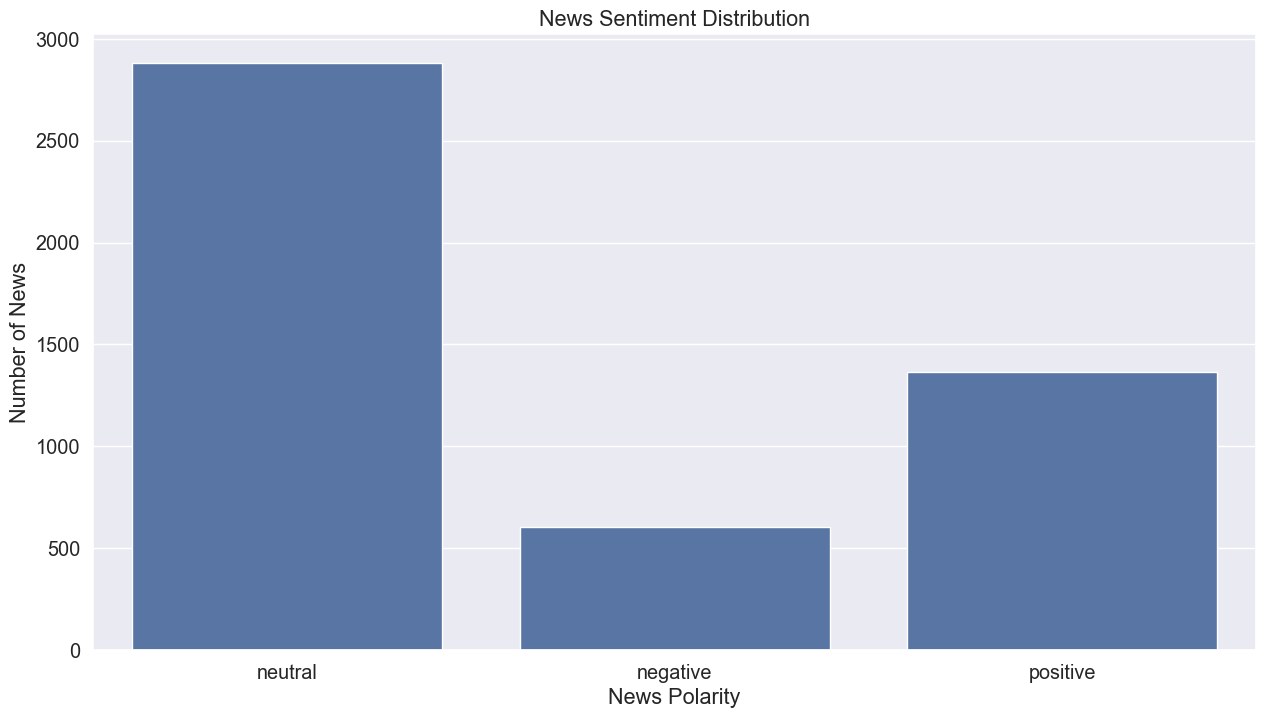

In [8]:

plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    

sns.set(font_scale=1.3)
sns.countplot(x='sentiment', data = financial_data)
plt.title('News Sentiment Distribution')
plt.xlabel('News Polarity')
plt.ylabel('Number of News')

In [9]:
show_random_headlines(5, financial_data)

Reviews #°1309
 - Sentiment: positive
 - News Headline: Overall , 50 percent of respondents were confident about their security when banking online .

Reviews #°772
 - Sentiment: positive
 - News Headline: Of the price , Kesko 's share is 10 mln euro $ 15.5 mln and it will recognize a gain of 4.0 mln euro $ 6.2 mln on the disposal which will be included in the result for the second quarter of 2008 .

Reviews #°1127
 - Sentiment: positive
 - News Headline: `` I 'm happy with the outcome , '' Sneed said after the hearing .

Reviews #°4395
 - Sentiment: negative
 - News Headline: Earnings per share ( EPS ) dropped to EUR 0.21 from EUR 0.31 .

Reviews #°3009
 - Sentiment: neutral
 - News Headline: Like all other mechanical pipettors from Biohit , also Proline Plus is CE-IVD marked and comes with a 3-year warranty .



In [10]:
financial_data, sentiment_dict = encode_sentiments_values(financial_data)

financial_data.head()

,sentiment,NewsHeadline,label
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,0
2,negative,The international electronic industry company ...,1
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


In [11]:
X_train, X_val, y_train, y_val = train_test_split(financial_data.index.values, 
                                                  financial_data.label.values, 
                                                  test_size = 0.15, 
                                                  random_state = 2022, 
                                                  stratify = financial_data.label.values)

In [ ]:
financial_data.loc[X_train, 'data_type'] = 'train'
financial_data.loc[X_val, 'data_type'] = 'val'


financial_data.groupby(['sentiment', 'label', 'data_type']).count()

NewsHeadline
sentiment label data_type              
negative  1     train               513
                val                  91
neutral   0     train              2447
                val                 432
positive  2     train              1159
                val                 204

In [13]:
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

In [14]:
headlines_sequence_lengths = get_headlines_len(financial_data)

Encoding in progress...


100%|██████████| 4846/4846 [00:02<00:00, 1645.09it/s]

End of Task.


Maximum Sequence Length is 150


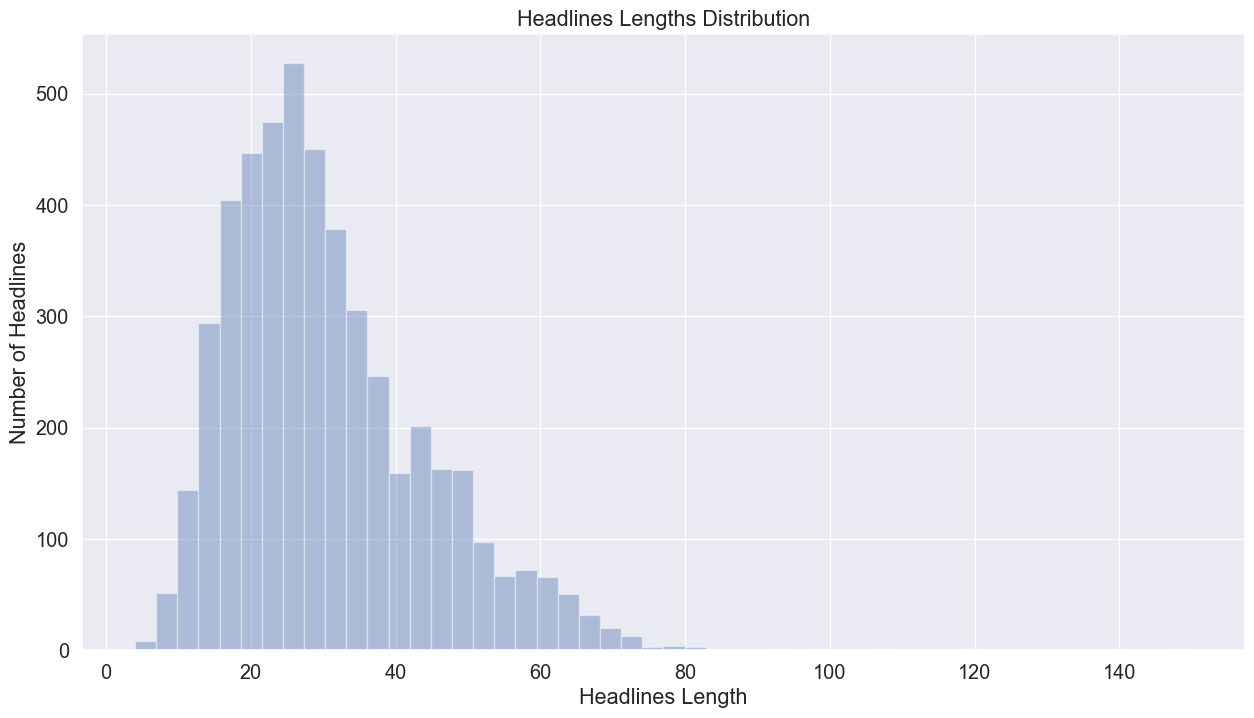

In [15]:
show_headline_distribution(headlines_sequence_lengths)

In [16]:
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='train'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 
)

encoded_data_val = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='val'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(financial_data[financial_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
sentiments_val = torch.tensor(financial_data[financial_data.data_type=='val'].label.values)


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, sentiments_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [17]:
len(sentiment_dict)

3

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=len(sentiment_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [19]:
batch_size = 5

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [20]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [21]:
seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_finBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/2 [05:50<?, ?it/s]


KeyboardInterrupt: 